In [67]:
import numpy as np
import pandas as pd
import pickle as pkl
import os
from os import listdir
from os.path import isfile, isdir, join
from numpy import linalg
from numpy import matrix
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds, eigs

In [68]:
#data_path = 'C:/Users/IsuzuPredator/Desktop/Tinayu_GUIDesign/Tianyu/preocessed_data/'
data_path = './processed_data/'
abnormal_data_path = data_path+'abnormal_data/' # 10 days prediction
abnormal_data_path_1 = data_path+'abnormal_data_1/' # day by day prediction
abnormal_data_path_20 = data_path + 'abnormal_data_20/' # 20 days prediction
normal_data_path = data_path+'normal_data/' # normal data (small)

In [69]:
# define correct and problem index and construct sensor dictionary
raw_correct_idx = [1,2,3,4,5,6,7,8,9,20,23,31,33,34,39,40,41,43,44,45,55,60,69,70,71,72,73,74,75,76,79,80,81,82,83] # depends
raw_problem_idx = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21,22,24,25,26,27,28,29,30,32,35,36,37,38,42,46,47,48,49,50,51,52,53,54,61,62,63,68,77,78]
correct_idx = []
problem_idx = []
for idx in raw_correct_idx:
    correct_idx.append(idx - 1)
#len(correct_idx) -->35
#len(problem_idx) -->40

for idx in raw_problem_idx:
    problem_idx.append(idx - 1)
sensor_dict = {}
sensor_list = ['1.[Accelerator pedal opening degree](%)', '2.[Actual Engine Torque](%)', '3.[Engine Speed](rpm)', '4.[Target fuel injection amount](mm3/st)', '5.[Current Gear]', '6.[Vehicle speed (25 pulses)](km/h)', '7.[CluchSW](MT only)', '8.[Brake SW]', '9.[Cruise Control Status]', '10.[coolant temperature](℃)', '11.[fuel temperature](℃)', '12.[Post injection Q](mm3)', '13.[Common rail pressure](MPa)', '14.[DPF differential pressure](kPa)', '15.[Atmospheric pressure](kPa)', '16.[Intake air temperature](℃)', '17.[Boost pressure](kPa)', '18.[CSF inlet temperature](℃)', '19.[DOC inlet temperature](℃)', '20.[DPF Status]', '21.[DPF error count]', '22.[DPF warning count]', '23.[DPF PM accumulation status]', '24.[DPF mileage status]', '25.[ITH Motor Protect Duty Limit Status]', '26.[EGR Motor Protect Duty Limit Status]', '27.[EGR Motor2 Protect Duty Limit Status]', '28.[DPF mode]', '29.[MAF](g/cyl)', '30.[EGR Duty](%)', '31.[EGR Target Position](%)','32.[EGR Actual Position](%)', '33.[Intake Throttle Duty](%)', '34.[Intake Throttle Target Position](%)', '35.[Intake Throttle Actual Position](%)', '36.[IGN Voltage](V)', '37.[RPCV Duty(medium small)・PCV Close Timing(large)](%・CA)', '38.[RPCV Actual Current(medium small)・PCV F/B Control Quantity(large)](mA・CA)', '39.[RPCV Desired Current(medium small)・EGR BLDC 2 Actual Position(large)](mA・%)', '40.[RPCV Commanded Fuel Flow(medium small)・EGR BLDC 2 Duty](mm3/sec・%)', '41.[Target Rail Pressure](Mpa)', '42.[VNT actual Position](%)', '43.[VNT Target Position](%)', '44.[Target Boost](%)', '45.[Engine Mode]', '46.[Mail SOI](CA)', '47.[Pilot SOI](CA)', '48.[CAM CRANK Synchro Status]', '49.[Cylinder1 Balancing Fuel Compensation](mm3/st)', '50.[Cylinder2 Balancing Fuel Compensation](mm3/st)', '51.[Cylinder3 Balancing Fuel Compensation](mm3/st)', '52.[Cylinder4 Balancing Fuel Compensation](mm3/st)', '53.[Cylinder5 Balancing Fuel Compensation](mm3/st)', '54.[Cylinder6 Balancing Fuel Compensation](mm3/st)', '55.[Target Idle rpm](rpm)', '56.[VGS Magnetic Valve Drive Status 1]', '57.[VGS Magnetic Valve Drive Status 2]', '58.[VGS Magnetic Valve Drive Status 3]', '59.[EGR cooler bypas valve]', '60.[Exhaust pipe INJ ON / OFF state](%)', '61.[Injection amount of exhaust pipe INJ](mm3/st)', '62.[Exhaust pipe INJ fuel pressure](kPa)', '63.[Compressor outlet temperature](℃)', '64.[Rail pressure reducing valve drive duty](%)', '65.[Rail pressure reducing valve target current](mA)', '66.[Rail pressure reducing valve actual current](mA)', '67.[Rail pressure reducing valve target pressure](MPa)', '68.[Turbo EVRV Duty output](%)', '69.[egr_bldc_pid_base_dc_1]', '70.[egr_bldc_pid_base_dc_2]', '71.[egr_bldc_p_term_fnl_1]', '72.[egr_bldc_p_term_fnl_2]', '73.[egr_bldc_i_term_fnl_1]', '74.[egr_bldc_i_term_fnl_2]', '75.[rpcv_dc_p_gain]', '76.[rpcv_dc_i_gain]', '77.[trb_trg_base_pos]', '78.[trb_map_fb_pos]', '79.[trb_map_p_term_fnl]', '80.[trb_map_i_term_fnl]', '81.[ith_dc_p_term]', '82.[ith_dc_i_term]', '83.[ith_dc_ff_fb]', '84.[CAC in sensor output]', '85.[CAC out sensor output]', '86.[Rail pressure sensor 2 output](MPa)', '87.[Sensor value O2](%)','88.[TBD]']

for item in sensor_list:
    sensor_number = int(item.split('.')[0])
    sensor_name = item.split('.')[1]
    sensor_dict[sensor_number] = sensor_name

In [70]:
def read_training_pickle(directory):
    '''
    description: stack training multiple pickle in a directory with sub directory
    input: directory path and error list
    output: a single pkl file
    '''
    error_list = []
    temp = directory.split('/')[-2]
    if isfile("./"+temp+".pkl"):
        print("File already exist, loading from", "./"+temp+".pkl")
        pkl = pd.read_pickle("./"+temp+".pkl")
        print("Loading done")
    else:
        print("Loading pickle files from", directory)
        pkl = pd.DataFrame() # create an empty df
        for subdir in os.listdir(directory):
            dir_path = directory+subdir
            print("----------------"+subdir+"----------------") # display
            for file in os.listdir(dir_path):
                print(file)
                file_path = dir_path+"/"+file
                new_file = pd.DataFrame(pd.read_pickle(file_path))[problem_idx]
                pkl = pd.concat((pkl, new_file),axis=0) # concat
        pkl.to_pickle("./"+temp+".pkl") # save
        print("Pickle file save in", "./"+"_label"+".pkl")
    return pkl

In [71]:
normal_pkl = read_training_pickle(normal_data_path)

File already exist, loading from ./normal_data.pkl
Loading done


In [72]:
normal_pkl.shape

(442522, 88)

In [73]:
def read_case(directory):
    """
    Description: read cases into a dictionary
    Input:directory path
    Output:list
    """
    pkl_list = []
    for sub_dir in os.listdir(directory):
        print('----------------------')
        print(sub_dir)
        sub_path = directory+sub_dir
        temp = []
        for pkl_file in os.listdir(sub_path):
            print(pkl_file)
            pkl_file_path = sub_path + '/' + pkl_file
            temp.append(pkl_file_path)
        pkl_list.append(temp)
    return pkl_list

In [74]:
normal_test_case = read_case(normal_data_path)

----------------------
3002LV234N3-----7000607output
70006072017_4_23.pkl
70006072017_4_24.pkl
70006072017_4_25.pkl
70006072017_4_26.pkl
70006072017_4_27.pkl
70006072017_4_28.pkl
70006072017_4_29.pkl
70006072017_4_30.pkl
70006072017_5_1.pkl
----------------------
3002LV234N3-----7000617output
70006172016_12_27.pkl
70006172016_12_28.pkl
70006172016_12_29.pkl
70006172016_12_30.pkl
70006172016_12_31.pkl
70006172017_1_1.pkl
70006172017_1_10.pkl
70006172017_1_11.pkl
70006172017_1_12.pkl
70006172017_1_13.pkl
70006172017_1_14.pkl
70006172017_1_15.pkl
70006172017_1_2.pkl
70006172017_1_3.pkl
70006172017_1_4.pkl
70006172017_1_5.pkl
70006172017_1_6.pkl
70006172017_1_7.pkl
70006172017_1_8.pkl
70006172017_1_9.pkl
----------------------
3002LV234N3-----7000619output
70006192016_11_11.pkl
70006192016_11_12.pkl
70006192016_11_13.pkl
70006192016_11_14.pkl
70006192016_11_15.pkl
70006192016_11_16.pkl
70006192016_11_17.pkl
70006192016_11_18.pkl
70006192016_11_19.pkl
70006192016_11_20.pkl
70006192016_11_21

In [75]:
abnormal_test_case = read_case(abnormal_data_path)

----------------------
3002LV234N3-----7000442output
70004422016_11_25.pkl
70004422016_11_26.pkl
70004422016_11_27.pkl
70004422016_11_28.pkl
70004422016_11_29.pkl
70004422016_11_30.pkl
70004422016_12_1.pkl
70004422016_12_2.pkl
70004422016_12_3.pkl
70004422016_12_5.pkl
----------------------
3002LV234N3-----7000607output
70006072015_4_10.pkl
70006072015_4_11.pkl
70006072015_4_12.pkl
70006072015_4_13.pkl
70006072015_4_14.pkl
70006072015_4_15.pkl
70006072015_4_16.pkl
70006072015_4_17.pkl
70006072015_4_8.pkl
70006072015_4_9.pkl
----------------------
3002LV234N3-----7000612output
70006122015_12_11.pkl
70006122015_12_12.pkl
70006122015_12_13.pkl
70006122015_12_14.pkl
70006122015_12_15.pkl
70006122015_12_16.pkl
70006122015_12_17.pkl
70006122015_12_18.pkl
70006122015_12_19.pkl
70006122015_12_20.pkl
70006122015_12_21.pkl
----------------------
3002LV234N3-----7000614output
70006142016_3_20.pkl
70006142016_3_21.pkl
70006142016_3_22.pkl
70006142016_3_23.pkl
70006142016_3_24.pkl
70006142016_3_25.

In [81]:
def pkl_to_matrix(pkl_file_path, train=1):
    """
    Description: convert pickle file to matrix, (add 1 at the head and tail)
    Input: pkl_file_path
    Output: matrix(row: 40 sensors | column : # of samples)
    """
    # load traning data from stacked pickle 
    if train == 1:
        temp = pkl_file_path.split('/')[-2]
        print(temp)
        if isfile("./"+temp+".pkl"): # normal_data
            #matrix = np.load("./"+temp+".pkl")[problem_idx]  # only use 40 problematic sensors
            matrix = np.load("./"+temp+".pkl")
            print("Convert", temp, "to matrix... Done")
        else:
            print("Error: normal_data.pkl doesn't exist. Call function {read_training_pickle} first.")
    
    # load test data, note only use labels
    else:
        if isfile(pkl_file_path):
            matrix = pd.DataFrame(pd.read_pickle(pkl_file_path))
            if matrix.shape[1] == 89:
                #print(pkl_file_path)
                matrix = matrix[list(range(88))]
            #matrix = matrix[problem_idx]  # only use 40 problematic sensors
        else:
            print("Error: file doesn't exist")
    return matrix.transpose()

In [82]:
def projection_matrix(matrix):
    """
    Description: compute the projection matrix of given data matrix
    Input: data matrix
    Output: projection matrix
    """
    #print(data_matrix)
    print("Rank of the matrix is", linalg.matrix_rank(matrix))
    #u,s,vt = linalg.svd(matrix, full_matrices=True) # memory error here
    u, s, _ = svds(matrix, k=35) # rank = 35
    print(u.shape)
    ur = u[:,::-1]
    plt.plot(s[::-1]) # sort
    plt.title('Singular values')
    return np.matmul(ur,ur.transpose()), s

normal_data
Convert normal_data to matrix... Done
Rank of the matrix is 68
(88, 35)


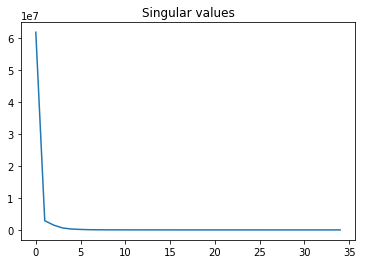

In [83]:
train_matrix = pkl_to_matrix(normal_data_path)
p, s = projection_matrix(train_matrix)

In [84]:
def projection_distance(matrix, projection):
    """
    Description: calculate the distance between a vector and a subspace(described as projeciton matrix)
    Input: vector: test samples
    Output: Euclidean distance
    """
    num = projection.shape[1]
    matrix_hat = np.matmul(projection, matrix)
    distance = 0
    matrix_difference = matrix_hat - matrix
    for i in range(matrix_difference.shape[1]): # sample vecor index
        temp = linalg.norm(matrix_difference[i])
        distance+=temp
    return distance/num

In [85]:
# calculate distance for 10 cases and plot the result for each case
if not isdir("./res_test_projection"):
    os.mkdir("./res_test_projection")

distance_test = []
for case in abnormal_test_case:

    temp = []
    fig_name = case[0].split('/')[-2][-9:-6]
    fig_name = './res_test_projection/' + fig_name
    date_list = []
    year = case[0].split('/')[-1].split('_')[0][-4:]
    month = case[0].split('/')[-1].split('_')[1]
    
    for file in case:
        if os.path.isfile(file):
            test_matrix = pkl_to_matrix(file, train=0)
            temp.append(projection_distance(test_matrix,p))
            date = file.split('/')[-1].split('_')[2].split('.')[0]
            date_list.append(date)
    
    # statistics calculation
    mean = np.mean(temp)
    variance = np.var(temp)


    # display and save figure
    print("-----------------------------")
    print("Plotting abnormal case start from", year+'/'+month)
    print("Dates", date_list)
    print("Mean: ",mean, "Variance: ", variance)
    print("Figure saved in", fig_name)

    plt.plot(temp)
    plt.xlabel('date')
    plt.ylabel('distance')
    plt.xticks(range(len(date_list)), date_list) # change when do 20 days prediction
    plt.title('Euclidean distance of case '+fig_name.split('/')[-1])
    plt.legend([year+'/'+month])
    
    plt.savefig(fig_name)
    plt.close()
    distance_test.append(temp)

-----------------------------
Plotting abnormal case start from 2016/11
Dates ['25', '26', '27', '28', '29', '30', '1', '2', '3', '5']
Mean:  nan Variance:  nan
Figure saved in ./res_test_projection/442
-----------------------------
Plotting abnormal case start from 2015/4
Dates ['10', '11', '12', '13', '14', '15', '16', '17', '8', '9']
Mean:  698.5719204867383 Variance:  77771.98687820401
Figure saved in ./res_test_projection/607
-----------------------------
Plotting abnormal case start from 2015/12
Dates ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
Mean:  526.6675961102491 Variance:  59175.08703174546
Figure saved in ./res_test_projection/612
-----------------------------
Plotting abnormal case start from 2016/3
Dates ['20', '21', '22', '23', '24', '25', '26', '27', '28', '29']
Mean:  683.6511146605881 Variance:  46987.31954210057
Figure saved in ./res_test_projection/614
-----------------------------
Plotting abnormal case start from 2016/10
Dates ['21', '22',

In [86]:
# plot for training
# calculate distance for 10 cases and plot the result for each case
if not isdir("./res_normal_projection"):
    os.mkdir("./res_normal_projection")

distance_train = []
for case in normal_test_case:

    temp = []
    fig_name = case[0].split('/')[-2][-9:-6]
    fig_name = './res_normal_projection/' + fig_name
    date_list = []
    year = case[0].split('/')[-1].split('_')[0][-4:]
    month = case[0].split('/')[-1].split('_')[1]
    
    for file in case:
        if os.path.isfile(file):
            test_matrix = pkl_to_matrix(file, train=0)
            temp.append(projection_distance(test_matrix,p))
            date = file.split('/')[-1].split('_')[2].split('.')[0]
            date_list.append(date)
    
    # statistics calculation
    mean = np.mean(temp)
    variance = np.var(temp)


    # display and save figure
    print("-----------------------------")
    print("Plotting abnormal case start from", year+'/'+month)
    print("Dates", date_list)
    print("Mean: ",mean, "Variance: ", variance)
    print("Figure saved in", fig_name)

    plt.plot(temp)
    plt.xlabel('date')
    plt.ylabel('distance')
    plt.xticks(range(len(date_list)), date_list) # change when do 20 days prediction
    plt.title('Euclidean distance of case '+fig_name.split('/')[-1])
    plt.legend([year+'/'+month])
    plt.savefig(fig_name)
    plt.close()
    distance_train.append(temp)

-----------------------------
Plotting abnormal case start from 2017/4
Dates ['23', '24', '25', '26', '27', '28', '29', '30', '1']
Mean:  341.9697141606909 Variance:  1443.9964387770285
Figure saved in ./res_normal_projection/607
-----------------------------
Plotting abnormal case start from 2016/12
Dates ['27', '28', '29', '30', '31', '1', '10', '11', '12', '13', '14', '15', '2', '3', '4', '5', '6', '7', '8', '9']
Mean:  369.77845512152214 Variance:  10019.493732912297
Figure saved in ./res_normal_projection/617
-----------------------------
Plotting abnormal case start from 2016/11
Dates ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Mean:  369.7484140895825 Variance:  6284.437258465306
Figure saved in ./res_normal_projection/619


In [87]:
def projection_distance_list(matrix, projection):
    """
    Description: calculate the distance between a vector and a subspace
    Input: vector: test samples
    Output: Euclidean distance of each sample: list
    """
    num = projection.shape[0]
    matrix_hat = np.matmul(projection, matrix)
    distance = []
    matrix_difference = matrix_hat - matrix
    for i in range(matrix_difference.shape[1]): # sample vecor index
        temp = linalg.norm(matrix_difference[i])
        distance.append(temp)
    return distance

In [88]:
# calculate distance for 10 cases and plot the result for each day
if not isdir("./res_test_projection_day"):
    os.mkdir("./res_test_projection_day")
    
for case in abnormal_test_case:
    fig_name_ = case[0].split('/')[-2][-9:-6]
    fig_name_ = './res_test_projection_day/' + fig_name_
    print(fig_name_)
    year = case[0].split('/')[-1].split('_')[0][-4:]
    month = case[0].split('/')[-1].split('_')[1]
    
    for file in case:
        if os.path.isfile(file):
            test_matrix = pkl_to_matrix(file, train=0)
            pred_dist = projection_distance_list(test_matrix, p)
            
            # statistics calculation
            mean = np.mean(pred_dist)
            variance = np.var(pred_dist)
            
            date = file.split('/')[-1].split('_')[2].split('.')[0]
            fig_name = fig_name_ + '_' + date
            
            # display and save figure
            print("-----------------------------")
            print("Plotting abnormal case at", year+'/'+month+'/'+date)
            print("Mean: ",mean, "Variance: ", variance)
            print("Figure saved in", fig_name)

            plt.plot(pred_dist)
            plt.xlabel('date')
            plt.ylabel('distance')
            plt.xlim(0,13000)
            plt.ylim(0,300)
            plt.title('Euclidean distance of case '+fig_name.split('/')[-1])
            plt.legend([year+'/'+month+'/'+date])
            plt.savefig(fig_name)
            plt.close()

./res_test_projection_day/442
-----------------------------
Plotting abnormal case at 2016/11/25
Mean:  4.644511530624103 Variance:  12.609805262430081
Figure saved in ./res_test_projection_day/442_25
-----------------------------
Plotting abnormal case at 2016/11/26
Mean:  4.751934244171979 Variance:  10.898169284199323
Figure saved in ./res_test_projection_day/442_26
-----------------------------
Plotting abnormal case at 2016/11/27
Mean:  4.29728819778759 Variance:  5.76414586879365
Figure saved in ./res_test_projection_day/442_27
-----------------------------
Plotting abnormal case at 2016/11/28
Mean:  5.0878391889089505 Variance:  16.047264315289254
Figure saved in ./res_test_projection_day/442_28
-----------------------------
Plotting abnormal case at 2016/11/29
Mean:  5.037277583064926 Variance:  32.10220308710275
Figure saved in ./res_test_projection_day/442_29
-----------------------------
Plotting abnormal case at 2016/11/30
Mean:  4.743597940539127 Variance:  9.3584807503919

-----------------------------
Plotting abnormal case at 2016/10/28
Mean:  4.0754621286435615 Variance:  6.071706168006347
Figure saved in ./res_test_projection_day/616_28
-----------------------------
Plotting abnormal case at 2016/10/29
Mean:  4.1463598420139185 Variance:  4.899927138909749
Figure saved in ./res_test_projection_day/616_29
-----------------------------
Plotting abnormal case at 2016/10/30
Mean:  4.9443590677754825 Variance:  20.055423853103875
Figure saved in ./res_test_projection_day/616_30
-----------------------------
Plotting abnormal case at 2016/10/31
Mean:  13.05925646793132 Variance:  871375.3152075862
Figure saved in ./res_test_projection_day/616_31
./res_test_projection_day/617
-----------------------------
Plotting abnormal case at 2016/4/15
Mean:  8.306696298517405 Variance:  32.80729407993062
Figure saved in ./res_test_projection_day/617_15
-----------------------------
Plotting abnormal case at 2016/4/19
Mean:  3.6630752362303434 Variance:  12.25189268537

In [66]:
# calculate distance for 10 cases and plot the result for each day
if not isdir("./res_normal_projection_day"):
    os.mkdir("./res_normal_projection_day")

for case in normal_test_case:
    fig_name_ = case[0].split('/')[-2][-9:-6]
    fig_name_ = './res_normal_projection_day/' + fig_name_
    print(fig_name_)
    year = case[0].split('/')[-1].split('_')[0][-4:]
    month = case[0].split('/')[-1].split('_')[1]
    
    for file in case:
        if os.path.isfile(file):
            test_matrix = pkl_to_matrix(file, train=0)
            pred_dist = projection_distance_list(test_matrix, p)
            
            # statistics calculation
            mean = np.mean(pred_dist)
            variance = np.var(pred_dist)
            
            date = file.split('/')[-1].split('_')[2].split('.')[0]
            fig_name = fig_name_ + '_' + date

            # display and save figure
            print("-----------------------------")
            print("Plotting abnormal case start from", year+'/'+month+'/'+date)
            print("Mean: ",mean, "Variance: ", variance)
            print("Figure saved in", fig_name)

            plt.plot(pred_dist)
            plt.xlabel('date')
            plt.ylabel('distance')
            plt.xlim(0,13000)
            plt.ylim(0,300)
            plt.title('Euclidean distance of case '+fig_name.split('/')[-1])
            plt.legend([year+'/'+month+'/'+date])
            plt.savefig(fig_name)
            plt.close()

./res_normal_projection_day/607
-----------------------------
Plotting abnormal case start from 2017/4/23
Mean:  0.002912499163167653 Variance:  8.453709492620245e-06
Figure saved in ./res_normal_projection_day/607_23
-----------------------------
Plotting abnormal case start from 2017/4/24
Mean:  0.002523301535946057 Variance:  4.638326303524605e-06
Figure saved in ./res_normal_projection_day/607_24
-----------------------------
Plotting abnormal case start from 2017/4/25
Mean:  0.0027593363202817905 Variance:  1.3959353650107215e-05
Figure saved in ./res_normal_projection_day/607_25
-----------------------------
Plotting abnormal case start from 2017/4/26
Mean:  0.0024341652105673065 Variance:  5.304616842253641e-06
Figure saved in ./res_normal_projection_day/607_26
-----------------------------
Plotting abnormal case start from 2017/4/27
Mean:  0.002991748336176985 Variance:  9.823837371251673e-06
Figure saved in ./res_normal_projection_day/607_27
-----------------------------
Plott

-----------------------------
Plotting abnormal case start from 2016/11/26
Mean:  0.0026915177971032138 Variance:  6.351871389105547e-06
Figure saved in ./res_normal_projection_day/619_26
-----------------------------
Plotting abnormal case start from 2016/11/27
Mean:  0.0020947112153716745 Variance:  3.5147680566007792e-06
Figure saved in ./res_normal_projection_day/619_27
-----------------------------
Plotting abnormal case start from 2016/11/28
Mean:  0.002642844353323073 Variance:  2.0755450140849058e-05
Figure saved in ./res_normal_projection_day/619_28
-----------------------------
Plotting abnormal case start from 2016/11/29
Mean:  0.0024732636521240165 Variance:  7.5848399695639675e-06
Figure saved in ./res_normal_projection_day/619_29
-----------------------------
Plotting abnormal case start from 2016/11/30
Mean:  0.0024382889047994748 Variance:  1.2106999247056065e-05
Figure saved in ./res_normal_projection_day/619_30
